# This notebook uses google-net for transfer learning to make predictions of apnea on the spectrograms for 60 seconds segments

Install libraries

In [ ]:
!pip install tqdm #install tqdm library on colab
!pip install torchmetrics
!pip install seaborn
!pip install scipy
!pip install sns
!pip install PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 28.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
from torch import optim 
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.utils.data as data_utils
import torchvision.transforms as transforms  

Set up device

In [ ]:
#set torch to CPU
device = torch.device("cpu") #set cpu for device
torch.cuda.is_available()

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Extract the images locally

In [ ]:
!unzip "/content/drive/My Drive/ML/Spectrogram_Hann.zip" -d "/content"

This cell defines useful constants

Change the path_c variable if google colab cannot be used

In [ ]:
path_c = '/content/'

out_directory_train = path_c + 'Spectrogram_Hann/Train/'
out_directory_test = path_c + 'Spectrogram_Hann/Test/'

# **pytorch model**

## DataSet class

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(
            csv_file
        )  # load data input and output from csv file
        self.annotations.columns = ["name", "label"]
        #encode annotation
        self.annotations["label"] = self.annotations["label"].apply(
            lambda x: 1 if x == "A" else 0
        )
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)  # return length of csv file

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

## Hyperparameters


In [ ]:
in_channels = 3
num_classes = 2
learning_rate = 0.001
batch_size = 16
num_epochs = 4

# Create loaders

Google-net requires a set of transformations to run.

We create the loaders from two spectrograms datasets, one for training and one for testing

In [ ]:
google_net_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

train_set = SpectrogramDataset(csv_file = out_directory_train + 'spc_train_labels.csv', root_dir = out_directory_train, transform = google_net_transform)
test_set = SpectrogramDataset(csv_file = out_directory_test + 'spc_test_labels.csv', root_dir = out_directory_test,transform = google_net_transform)
 
train_loader = DataLoader(dataset= train_set, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(dataset= test_set, batch_size = batch_size, shuffle =True)

## Load the google-net model

We need change the number of classes for prediction, therefore change the shape of the final layer (model.fc) of the model with the out_features parameter

In [ ]:
model = torchvision.models.googlenet(pretrained = True)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)

# **Train model**

Loss and optimizer

In [ ]:
# Loss and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## Train Network and calculate accuracy and loss

In [ ]:
losses = []
accur = []
losses_test = []
accur_test = []
for epoch in range(num_epochs):
  i = 0 
  running_loss =0.0
  for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device=device)
    targets = targets.to(device=device)
    data = data.float() 
    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()
    running_loss += loss.item()
    i+=1
    if i % 10 == 9:    # print every 4 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
        running_loss = 0.0

  0%|          | 4/856 [00:16<56:41,  3.99s/it]

[1,     5] loss: 0.509


  1%|          | 9/856 [00:37<1:00:39,  4.30s/it]

[1,    10] loss: 0.580


  2%|▏         | 14/856 [00:58<56:22,  4.02s/it]

[1,    15] loss: 0.620


  2%|▏         | 19/856 [01:17<52:55,  3.79s/it]

[1,    20] loss: 0.494


  3%|▎         | 24/856 [01:35<51:45,  3.73s/it]

[1,    25] loss: 0.578


  3%|▎         | 29/856 [01:54<51:33,  3.74s/it]

[1,    30] loss: 0.455


  4%|▍         | 34/856 [02:13<51:20,  3.75s/it]

[1,    35] loss: 0.661


  5%|▍         | 39/856 [02:32<50:52,  3.74s/it]

[1,    40] loss: 0.584


  5%|▌         | 44/856 [02:50<50:10,  3.71s/it]

[1,    45] loss: 0.549


  6%|▌         | 49/856 [03:09<49:29,  3.68s/it]

[1,    50] loss: 0.536


  6%|▋         | 54/856 [03:29<56:23,  4.22s/it]

[1,    55] loss: 0.575


  7%|▋         | 59/856 [03:51<55:40,  4.19s/it]

[1,    60] loss: 0.424


  7%|▋         | 64/856 [04:10<49:51,  3.78s/it]

[1,    65] loss: 0.444


  8%|▊         | 69/856 [04:28<48:39,  3.71s/it]

[1,    70] loss: 0.460


  9%|▊         | 74/856 [04:47<48:37,  3.73s/it]

[1,    75] loss: 0.501


  9%|▉         | 79/856 [05:06<48:07,  3.72s/it]

[1,    80] loss: 0.403


 10%|▉         | 84/856 [05:24<47:49,  3.72s/it]

[1,    85] loss: 0.374


 10%|█         | 89/856 [05:43<47:35,  3.72s/it]

[1,    90] loss: 0.361


 11%|█         | 94/856 [06:01<47:36,  3.75s/it]

[1,    95] loss: 0.418


 12%|█▏        | 99/856 [06:20<47:07,  3.73s/it]

[1,   100] loss: 0.389


 12%|█▏        | 104/856 [06:40<51:39,  4.12s/it]

[1,   105] loss: 0.352


 13%|█▎        | 109/856 [07:00<49:03,  3.94s/it]

[1,   110] loss: 0.624


 13%|█▎        | 114/856 [07:19<46:11,  3.74s/it]

[1,   115] loss: 0.349


 14%|█▍        | 119/856 [07:37<46:33,  3.79s/it]

[1,   120] loss: 0.403


 14%|█▍        | 124/856 [07:59<48:14,  3.95s/it]

[1,   125] loss: 0.393


 15%|█▌        | 129/856 [08:18<45:29,  3.75s/it]

[1,   130] loss: 0.367


 16%|█▌        | 134/856 [08:36<44:38,  3.71s/it]

[1,   135] loss: 0.568


 16%|█▌        | 139/856 [08:55<44:25,  3.72s/it]

[1,   140] loss: 0.492


 17%|█▋        | 144/856 [09:13<44:02,  3.71s/it]

[1,   145] loss: 0.430


 17%|█▋        | 149/856 [09:32<43:45,  3.71s/it]

[1,   150] loss: 0.368


 18%|█▊        | 154/856 [09:53<48:28,  4.14s/it]

[1,   155] loss: 0.437


 19%|█▊        | 159/856 [10:12<43:44,  3.77s/it]

[1,   160] loss: 0.359


 19%|█▉        | 164/856 [10:30<42:30,  3.69s/it]

[1,   165] loss: 0.390


 20%|█▉        | 169/856 [10:48<41:50,  3.65s/it]

[1,   170] loss: 0.439


 20%|██        | 174/856 [11:06<41:36,  3.66s/it]

[1,   175] loss: 0.398


 21%|██        | 179/856 [11:25<41:07,  3.65s/it]

[1,   180] loss: 0.370


 21%|██▏       | 184/856 [11:43<41:01,  3.66s/it]

[1,   185] loss: 0.375


 22%|██▏       | 189/856 [12:01<40:23,  3.63s/it]

[1,   190] loss: 0.425


 23%|██▎       | 194/856 [12:22<42:50,  3.88s/it]

[1,   195] loss: 0.348


 23%|██▎       | 199/856 [12:41<42:36,  3.89s/it]

[1,   200] loss: 0.427


 24%|██▍       | 204/856 [13:01<42:38,  3.92s/it]

[1,   205] loss: 0.412


 24%|██▍       | 209/856 [13:20<39:56,  3.70s/it]

[1,   210] loss: 0.322


 25%|██▌       | 214/856 [13:38<39:52,  3.73s/it]

[1,   215] loss: 0.395


 26%|██▌       | 219/856 [13:57<39:01,  3.68s/it]

[1,   220] loss: 0.376


 26%|██▌       | 224/856 [14:15<38:42,  3.68s/it]

[1,   225] loss: 0.585


 27%|██▋       | 229/856 [14:33<38:01,  3.64s/it]

[1,   230] loss: 0.397


 27%|██▋       | 234/856 [14:51<37:51,  3.65s/it]

[1,   235] loss: 0.483


 28%|██▊       | 239/856 [15:10<37:40,  3.66s/it]

[1,   240] loss: 0.452


 29%|██▊       | 244/856 [15:28<37:47,  3.71s/it]

[1,   245] loss: 0.403


 29%|██▉       | 249/856 [15:47<37:15,  3.68s/it]

[1,   250] loss: 0.358


 30%|██▉       | 254/856 [16:05<36:40,  3.65s/it]

[1,   255] loss: 0.411


 30%|███       | 259/856 [16:26<44:58,  4.52s/it]

[1,   260] loss: 0.334


 31%|███       | 264/856 [16:46<40:02,  4.06s/it]

[1,   265] loss: 0.497


 31%|███▏      | 269/856 [17:05<40:30,  4.14s/it]

[1,   270] loss: 0.318


 32%|███▏      | 274/856 [17:24<36:19,  3.74s/it]

[1,   275] loss: 0.408


 33%|███▎      | 279/856 [17:42<35:06,  3.65s/it]

[1,   280] loss: 0.400


 33%|███▎      | 284/856 [18:00<34:42,  3.64s/it]

[1,   285] loss: 0.376


 34%|███▍      | 289/856 [18:18<34:30,  3.65s/it]

[1,   290] loss: 0.512


 34%|███▍      | 294/856 [18:37<34:07,  3.64s/it]

[1,   295] loss: 0.425


 35%|███▍      | 299/856 [18:55<34:14,  3.69s/it]

[1,   300] loss: 0.308


 36%|███▌      | 304/856 [19:13<33:43,  3.66s/it]

[1,   305] loss: 0.355


 36%|███▌      | 309/856 [19:32<33:43,  3.70s/it]

[1,   310] loss: 0.461


 37%|███▋      | 314/856 [19:50<33:09,  3.67s/it]

[1,   315] loss: 0.318


 37%|███▋      | 319/856 [20:10<33:55,  3.79s/it]

[1,   320] loss: 0.278


 38%|███▊      | 324/856 [20:30<35:42,  4.03s/it]

[1,   325] loss: 0.516


 38%|███▊      | 329/856 [20:48<32:40,  3.72s/it]

[1,   330] loss: 0.372


 39%|███▉      | 334/856 [21:09<35:58,  4.14s/it]

[1,   335] loss: 0.375


 40%|███▉      | 339/856 [21:28<32:07,  3.73s/it]

[1,   340] loss: 0.331


 40%|████      | 344/856 [21:46<30:59,  3.63s/it]

[1,   345] loss: 0.348


 41%|████      | 349/856 [22:04<30:33,  3.62s/it]

[1,   350] loss: 0.393


 41%|████▏     | 354/856 [22:22<30:27,  3.64s/it]

[1,   355] loss: 0.299


 42%|████▏     | 359/856 [22:40<30:11,  3.64s/it]

[1,   360] loss: 0.379


 43%|████▎     | 364/856 [22:59<30:56,  3.77s/it]

[1,   365] loss: 0.420


 43%|████▎     | 369/856 [23:18<30:14,  3.73s/it]

[1,   370] loss: 0.429


 44%|████▎     | 374/856 [23:37<30:48,  3.83s/it]

[1,   375] loss: 0.436


 44%|████▍     | 379/856 [23:55<29:09,  3.67s/it]

[1,   380] loss: 0.397


 45%|████▍     | 384/856 [24:14<29:10,  3.71s/it]

[1,   385] loss: 0.534


 45%|████▌     | 389/856 [24:32<28:24,  3.65s/it]

[1,   390] loss: 0.443


 46%|████▌     | 394/856 [24:50<28:07,  3.65s/it]

[1,   395] loss: 0.398


 47%|████▋     | 399/856 [25:09<27:54,  3.66s/it]

[1,   400] loss: 0.328


 47%|████▋     | 404/856 [25:30<31:58,  4.25s/it]

[1,   405] loss: 0.341


 48%|████▊     | 409/856 [25:48<27:47,  3.73s/it]

[1,   410] loss: 0.289


 48%|████▊     | 414/856 [26:07<29:38,  4.02s/it]

[1,   415] loss: 0.484


 49%|████▉     | 419/856 [26:26<27:03,  3.71s/it]

[1,   420] loss: 0.364


 50%|████▉     | 424/856 [26:45<27:17,  3.79s/it]

[1,   425] loss: 0.466


 50%|█████     | 429/856 [27:03<26:01,  3.66s/it]

[1,   430] loss: 0.289


 51%|█████     | 434/856 [27:22<25:35,  3.64s/it]

[1,   435] loss: 0.380


 51%|█████▏    | 439/856 [27:40<25:10,  3.62s/it]

[1,   440] loss: 0.283


 52%|█████▏    | 444/856 [27:58<24:56,  3.63s/it]

[1,   445] loss: 0.303


 52%|█████▏    | 449/856 [28:16<24:30,  3.61s/it]

[1,   450] loss: 0.208


 53%|█████▎    | 454/856 [28:34<24:34,  3.67s/it]

[1,   455] loss: 0.362


 54%|█████▎    | 459/856 [28:53<24:08,  3.65s/it]

[1,   460] loss: 0.433


 54%|█████▍    | 464/856 [29:11<23:40,  3.62s/it]

[1,   465] loss: 0.493


 55%|█████▍    | 469/856 [29:29<23:18,  3.61s/it]

[1,   470] loss: 0.482


 55%|█████▌    | 474/856 [29:47<23:02,  3.62s/it]

[1,   475] loss: 0.434


 56%|█████▌    | 479/856 [30:06<23:34,  3.75s/it]

[1,   480] loss: 0.266


 57%|█████▋    | 484/856 [30:25<22:40,  3.66s/it]

[1,   485] loss: 0.324


 57%|█████▋    | 489/856 [30:47<24:51,  4.06s/it]

[1,   490] loss: 0.318


 58%|█████▊    | 494/856 [31:05<22:14,  3.69s/it]

[1,   495] loss: 0.405


 58%|█████▊    | 499/856 [31:23<21:29,  3.61s/it]

[1,   500] loss: 0.414


 59%|█████▉    | 504/856 [31:41<21:08,  3.60s/it]

[1,   505] loss: 0.257


 59%|█████▉    | 509/856 [31:59<20:51,  3.61s/it]

[1,   510] loss: 0.345


 60%|██████    | 514/856 [32:17<20:37,  3.62s/it]

[1,   515] loss: 0.361


 61%|██████    | 519/856 [32:35<20:16,  3.61s/it]

[1,   520] loss: 0.306


 61%|██████    | 524/856 [32:54<20:00,  3.61s/it]

[1,   525] loss: 0.277


 62%|██████▏   | 529/856 [33:13<20:32,  3.77s/it]

[1,   530] loss: 0.376


 62%|██████▏   | 534/856 [33:31<19:32,  3.64s/it]

[1,   535] loss: 0.355


 63%|██████▎   | 539/856 [33:49<19:11,  3.63s/it]

[1,   540] loss: 0.236


 64%|██████▎   | 544/856 [34:08<18:59,  3.65s/it]

[1,   545] loss: 0.293


 64%|██████▍   | 549/856 [34:26<18:36,  3.64s/it]

[1,   550] loss: 0.559


 65%|██████▍   | 554/856 [34:44<18:11,  3.61s/it]

[1,   555] loss: 0.398


 65%|██████▌   | 559/856 [35:02<17:47,  3.59s/it]

[1,   560] loss: 0.393


 66%|██████▌   | 564/856 [35:21<18:42,  3.85s/it]

[1,   565] loss: 0.330


 66%|██████▋   | 569/856 [35:39<17:22,  3.63s/it]

[1,   570] loss: 0.334


 67%|██████▋   | 574/856 [36:01<20:42,  4.41s/it]

[1,   575] loss: 0.292


 68%|██████▊   | 579/856 [36:21<18:13,  3.95s/it]

[1,   580] loss: 0.457


 68%|██████▊   | 584/856 [36:39<16:36,  3.66s/it]

[1,   585] loss: 0.401


 69%|██████▉   | 589/856 [36:57<16:07,  3.62s/it]

[1,   590] loss: 0.330


 69%|██████▉   | 594/856 [37:15<15:56,  3.65s/it]

[1,   595] loss: 0.325


 70%|██████▉   | 599/856 [37:33<15:31,  3.62s/it]

[1,   600] loss: 0.355


 71%|███████   | 604/856 [37:51<15:13,  3.63s/it]

[1,   605] loss: 0.520


 71%|███████   | 609/856 [38:09<14:50,  3.60s/it]

[1,   610] loss: 0.286


 72%|███████▏  | 614/856 [38:29<16:02,  3.98s/it]

[1,   615] loss: 0.284


 72%|███████▏  | 619/856 [38:47<14:39,  3.71s/it]

[1,   620] loss: 0.342


 73%|███████▎  | 624/856 [39:05<13:57,  3.61s/it]

[1,   625] loss: 0.210


 73%|███████▎  | 629/856 [39:23<13:44,  3.63s/it]

[1,   630] loss: 0.561


 74%|███████▍  | 634/856 [39:41<13:18,  3.60s/it]

[1,   635] loss: 0.361


 75%|███████▍  | 639/856 [40:01<13:27,  3.72s/it]

[1,   640] loss: 0.309


 75%|███████▌  | 644/856 [40:19<12:58,  3.67s/it]

[1,   645] loss: 0.322


 76%|███████▌  | 649/856 [40:37<12:29,  3.62s/it]

[1,   650] loss: 0.297


 76%|███████▋  | 654/856 [40:58<13:35,  4.04s/it]

[1,   655] loss: 0.312


 77%|███████▋  | 659/856 [41:17<12:06,  3.69s/it]

[1,   660] loss: 0.360


 78%|███████▊  | 664/856 [41:36<12:57,  4.05s/it]

[1,   665] loss: 0.389


 78%|███████▊  | 669/856 [41:54<11:31,  3.70s/it]

[1,   670] loss: 0.461


 79%|███████▊  | 674/856 [42:12<10:58,  3.62s/it]

[1,   675] loss: 0.470


 79%|███████▉  | 679/856 [42:30<10:37,  3.60s/it]

[1,   680] loss: 0.362


 80%|███████▉  | 684/856 [42:48<10:23,  3.63s/it]

[1,   685] loss: 0.285


 80%|████████  | 689/856 [43:08<10:36,  3.81s/it]

[1,   690] loss: 0.349


 81%|████████  | 694/856 [43:26<09:50,  3.64s/it]

[1,   695] loss: 0.211


 82%|████████▏ | 699/856 [43:44<09:23,  3.59s/it]

[1,   700] loss: 0.409


 82%|████████▏ | 704/856 [44:02<09:09,  3.62s/it]

[1,   705] loss: 0.288


 83%|████████▎ | 709/856 [44:20<08:51,  3.62s/it]

[1,   710] loss: 0.440


 83%|████████▎ | 714/856 [44:38<08:32,  3.61s/it]

[1,   715] loss: 0.378


 84%|████████▍ | 719/856 [44:56<08:17,  3.63s/it]

[1,   720] loss: 0.326


 85%|████████▍ | 724/856 [45:14<07:57,  3.61s/it]

[1,   725] loss: 0.390


 85%|████████▌ | 729/856 [45:34<08:03,  3.81s/it]

[1,   730] loss: 0.545


 86%|████████▌ | 734/856 [45:55<08:20,  4.10s/it]

[1,   735] loss: 0.391


 86%|████████▋ | 739/856 [46:14<07:56,  4.08s/it]

[1,   740] loss: 0.276


 87%|████████▋ | 744/856 [46:33<06:57,  3.73s/it]

[1,   745] loss: 0.351


 88%|████████▊ | 749/856 [46:51<06:30,  3.65s/it]

[1,   750] loss: 0.253


 88%|████████▊ | 754/856 [47:09<06:11,  3.64s/it]

[1,   755] loss: 0.335


 89%|████████▊ | 759/856 [47:27<05:52,  3.64s/it]

[1,   760] loss: 0.300


 89%|████████▉ | 764/856 [47:45<05:37,  3.67s/it]

[1,   765] loss: 0.213


 90%|████████▉ | 769/856 [48:03<05:15,  3.63s/it]

[1,   770] loss: 0.330


 90%|█████████ | 774/856 [48:22<04:58,  3.64s/it]

[1,   775] loss: 0.341


 91%|█████████ | 779/856 [48:41<05:04,  3.96s/it]

[1,   780] loss: 0.191


 92%|█████████▏| 784/856 [48:59<04:26,  3.70s/it]

[1,   785] loss: 0.349


 92%|█████████▏| 789/856 [49:17<04:03,  3.64s/it]

[1,   790] loss: 0.260


 93%|█████████▎| 794/856 [49:35<03:43,  3.61s/it]

[1,   795] loss: 0.382


 93%|█████████▎| 799/856 [49:53<03:25,  3.61s/it]

[1,   800] loss: 0.351


 94%|█████████▍| 804/856 [50:13<03:18,  3.82s/it]

[1,   805] loss: 0.299


 95%|█████████▍| 809/856 [50:31<02:51,  3.65s/it]

[1,   810] loss: 0.361


 95%|█████████▌| 814/856 [50:49<02:33,  3.66s/it]

[1,   815] loss: 0.375


 96%|█████████▌| 819/856 [51:10<02:22,  3.84s/it]

[1,   820] loss: 0.294


 96%|█████████▋| 824/856 [51:28<01:56,  3.65s/it]

[1,   825] loss: 0.356


 97%|█████████▋| 829/856 [51:46<01:37,  3.59s/it]

[1,   830] loss: 0.312


 97%|█████████▋| 834/856 [52:06<01:24,  3.84s/it]

[1,   835] loss: 0.368


 98%|█████████▊| 839/856 [52:24<01:02,  3.67s/it]

[1,   840] loss: 0.296


 99%|█████████▊| 844/856 [52:42<00:43,  3.65s/it]

[1,   845] loss: 0.343


 99%|█████████▉| 849/856 [53:00<00:25,  3.65s/it]

[1,   850] loss: 0.277


100%|█████████▉| 854/856 [53:19<00:07,  3.81s/it]

[1,   855] loss: 0.465


  0%|          | 4/856 [00:14<51:10,  3.60s/it]

[2,     5] loss: 0.179


  1%|          | 9/856 [00:32<51:04,  3.62s/it]

[2,    10] loss: 0.286


  2%|▏         | 14/856 [00:50<50:48,  3.62s/it]

[2,    15] loss: 0.377


  2%|▏         | 19/856 [01:08<50:17,  3.61s/it]

[2,    20] loss: 0.292


  3%|▎         | 24/856 [01:26<50:00,  3.61s/it]

[2,    25] loss: 0.264


  3%|▎         | 29/856 [01:44<49:44,  3.61s/it]

[2,    30] loss: 0.411


  4%|▍         | 34/856 [02:02<49:26,  3.61s/it]

[2,    35] loss: 0.300


  5%|▍         | 39/856 [02:23<57:58,  4.26s/it]

[2,    40] loss: 0.284


  5%|▌         | 44/856 [02:43<52:20,  3.87s/it]

[2,    45] loss: 0.479


  6%|▌         | 49/856 [03:01<49:34,  3.69s/it]

[2,    50] loss: 0.204


  6%|▋         | 54/856 [03:20<51:12,  3.83s/it]

[2,    55] loss: 0.264


  7%|▋         | 59/856 [03:38<48:11,  3.63s/it]

[2,    60] loss: 0.292


  7%|▋         | 64/856 [03:57<48:14,  3.65s/it]

[2,    65] loss: 0.218


  8%|▊         | 69/856 [04:15<47:41,  3.64s/it]

[2,    70] loss: 0.287


  9%|▊         | 74/856 [04:33<47:03,  3.61s/it]

[2,    75] loss: 0.352


  9%|▉         | 79/856 [04:51<46:47,  3.61s/it]

[2,    80] loss: 0.364


 10%|▉         | 84/856 [05:09<46:21,  3.60s/it]

[2,    85] loss: 0.343


 10%|█         | 89/856 [05:27<45:53,  3.59s/it]

[2,    90] loss: 0.311


 11%|█         | 94/856 [05:46<48:03,  3.78s/it]

[2,    95] loss: 0.403


 12%|█▏        | 99/856 [06:04<45:52,  3.64s/it]

[2,   100] loss: 0.307


 12%|█▏        | 104/856 [06:22<45:22,  3.62s/it]

[2,   105] loss: 0.360


 13%|█▎        | 109/856 [06:40<45:01,  3.62s/it]

[2,   110] loss: 0.294


 13%|█▎        | 114/856 [07:00<45:55,  3.71s/it]

[2,   115] loss: 0.349


 14%|█▍        | 119/856 [07:18<44:22,  3.61s/it]

[2,   120] loss: 0.405


 14%|█▍        | 124/856 [07:39<46:42,  3.83s/it]

[2,   125] loss: 0.298


 15%|█▌        | 129/856 [07:57<44:26,  3.67s/it]

[2,   130] loss: 0.308


 16%|█▌        | 134/856 [08:15<43:36,  3.62s/it]

[2,   135] loss: 0.369


 16%|█▌        | 139/856 [08:33<43:03,  3.60s/it]

[2,   140] loss: 0.309


 17%|█▋        | 144/856 [08:51<42:50,  3.61s/it]

[2,   145] loss: 0.368


 17%|█▋        | 149/856 [09:11<47:27,  4.03s/it]

[2,   150] loss: 0.255


 18%|█▊        | 154/856 [09:29<43:18,  3.70s/it]

[2,   155] loss: 0.202


 19%|█▊        | 159/856 [09:47<42:28,  3.66s/it]

[2,   160] loss: 0.355


 19%|█▉        | 164/856 [10:07<45:46,  3.97s/it]

[2,   165] loss: 0.413


 20%|█▉        | 169/856 [10:25<42:16,  3.69s/it]

[2,   170] loss: 0.373


 20%|██        | 174/856 [10:43<41:15,  3.63s/it]

[2,   175] loss: 0.299


 21%|██        | 179/856 [11:01<41:28,  3.68s/it]

[2,   180] loss: 0.277


 21%|██▏       | 184/856 [11:19<40:32,  3.62s/it]

[2,   185] loss: 0.363


 22%|██▏       | 189/856 [11:37<40:06,  3.61s/it]

[2,   190] loss: 0.355


 23%|██▎       | 194/856 [11:55<39:47,  3.61s/it]

[2,   195] loss: 0.281


 23%|██▎       | 199/856 [12:16<47:16,  4.32s/it]

[2,   200] loss: 0.200


 24%|██▍       | 204/856 [12:36<42:58,  3.96s/it]

[2,   205] loss: 0.376


 24%|██▍       | 209/856 [12:54<39:36,  3.67s/it]

[2,   210] loss: 0.242


 25%|██▌       | 214/856 [13:12<38:46,  3.62s/it]

[2,   215] loss: 0.345


 26%|██▌       | 219/856 [13:32<40:21,  3.80s/it]

[2,   220] loss: 0.229


 26%|██▌       | 224/856 [13:50<38:24,  3.65s/it]

[2,   225] loss: 0.215


 27%|██▋       | 229/856 [14:08<37:45,  3.61s/it]

[2,   230] loss: 0.480


 27%|██▋       | 234/856 [14:26<37:52,  3.65s/it]

[2,   235] loss: 0.328


 28%|██▊       | 239/856 [14:44<37:19,  3.63s/it]

[2,   240] loss: 0.303


 29%|██▊       | 244/856 [15:03<37:08,  3.64s/it]

[2,   245] loss: 0.281


 29%|██▉       | 249/856 [15:21<36:34,  3.62s/it]

[2,   250] loss: 0.328


 30%|██▉       | 254/856 [15:39<36:17,  3.62s/it]

[2,   255] loss: 0.356


 30%|███       | 259/856 [15:58<39:48,  4.00s/it]

[2,   260] loss: 0.288


 31%|███       | 264/856 [16:16<36:11,  3.67s/it]

[2,   265] loss: 0.369


 31%|███▏      | 269/856 [16:34<35:33,  3.63s/it]

[2,   270] loss: 0.234


 32%|███▏      | 274/856 [16:52<35:03,  3.61s/it]

[2,   275] loss: 0.410


 33%|███▎      | 279/856 [17:15<43:30,  4.52s/it]

[2,   280] loss: 0.302


 33%|███▎      | 284/856 [17:33<36:12,  3.80s/it]

[2,   285] loss: 0.266


 34%|███▍      | 289/856 [17:51<34:20,  3.63s/it]

[2,   290] loss: 0.253


 34%|███▍      | 294/856 [18:09<34:16,  3.66s/it]

[2,   295] loss: 0.269


 35%|███▍      | 299/856 [18:28<34:29,  3.72s/it]

[2,   300] loss: 0.332


 36%|███▌      | 304/856 [18:46<33:38,  3.66s/it]

[2,   305] loss: 0.363


 36%|███▌      | 309/856 [19:04<32:58,  3.62s/it]

[2,   310] loss: 0.386


 37%|███▋      | 314/856 [19:24<35:19,  3.91s/it]

[2,   315] loss: 0.251


 37%|███▋      | 319/856 [19:42<32:37,  3.65s/it]

[2,   320] loss: 0.216


 38%|███▊      | 324/856 [20:00<31:53,  3.60s/it]

[2,   325] loss: 0.253


 38%|███▊      | 329/856 [20:18<31:43,  3.61s/it]

[2,   330] loss: 0.435


 39%|███▉      | 334/856 [20:36<31:36,  3.63s/it]

[2,   335] loss: 0.246


 40%|███▉      | 339/856 [20:54<31:05,  3.61s/it]

[2,   340] loss: 0.319


 40%|████      | 344/856 [21:13<32:27,  3.80s/it]

[2,   345] loss: 0.288


 41%|████      | 349/856 [21:32<31:48,  3.77s/it]

[2,   350] loss: 0.277


 41%|████▏     | 354/856 [21:50<30:40,  3.67s/it]

[2,   355] loss: 0.398


 42%|████▏     | 359/856 [22:10<32:42,  3.95s/it]

[2,   360] loss: 0.391


 43%|████▎     | 364/856 [22:29<32:25,  3.95s/it]

[2,   365] loss: 0.242


 43%|████▎     | 369/856 [22:49<32:45,  4.04s/it]

[2,   370] loss: 0.396


 44%|████▎     | 374/856 [23:07<29:47,  3.71s/it]

[2,   375] loss: 0.430


 44%|████▍     | 379/856 [23:25<28:57,  3.64s/it]

[2,   380] loss: 0.221


 45%|████▍     | 384/856 [23:44<28:50,  3.67s/it]

[2,   385] loss: 0.295


 45%|████▌     | 389/856 [24:02<28:14,  3.63s/it]

[2,   390] loss: 0.264


 46%|████▌     | 394/856 [24:20<27:49,  3.61s/it]

[2,   395] loss: 0.264


 47%|████▋     | 399/856 [24:38<27:25,  3.60s/it]

[2,   400] loss: 0.302


 47%|████▋     | 404/856 [24:57<27:52,  3.70s/it]

[2,   405] loss: 0.297


 48%|████▊     | 409/856 [25:15<26:55,  3.62s/it]

[2,   410] loss: 0.306


 48%|████▊     | 414/856 [25:35<29:18,  3.98s/it]

[2,   415] loss: 0.250


 49%|████▉     | 419/856 [25:54<29:12,  4.01s/it]

[2,   420] loss: 0.346


 50%|████▉     | 424/856 [26:14<30:04,  4.18s/it]

[2,   425] loss: 0.248


 50%|█████     | 429/856 [26:32<26:39,  3.75s/it]

[2,   430] loss: 0.309


 51%|█████     | 434/856 [26:51<25:59,  3.70s/it]

[2,   435] loss: 0.277


 51%|█████▏    | 439/856 [27:09<25:15,  3.63s/it]

[2,   440] loss: 0.572


 52%|█████▏    | 444/856 [27:27<24:47,  3.61s/it]

[2,   445] loss: 0.380


 52%|█████▏    | 449/856 [27:45<24:23,  3.60s/it]

[2,   450] loss: 0.410


 53%|█████▎    | 454/856 [28:03<24:25,  3.65s/it]

[2,   455] loss: 0.335


 54%|█████▎    | 459/856 [28:23<25:08,  3.80s/it]

[2,   460] loss: 0.397


 54%|█████▍    | 464/856 [28:41<24:19,  3.72s/it]

[2,   465] loss: 0.198


 55%|█████▍    | 469/856 [29:01<26:36,  4.12s/it]

[2,   470] loss: 0.276


 55%|█████▌    | 474/856 [29:21<26:11,  4.11s/it]

[2,   475] loss: 0.341


 56%|█████▌    | 479/856 [29:40<24:45,  3.94s/it]

[2,   480] loss: 0.204


 57%|█████▋    | 484/856 [29:59<23:48,  3.84s/it]

[2,   485] loss: 0.323


 57%|█████▋    | 489/856 [30:17<22:36,  3.69s/it]

[2,   490] loss: 0.246


 58%|█████▊    | 494/856 [30:35<21:56,  3.64s/it]

[2,   495] loss: 0.421


 58%|█████▊    | 499/856 [30:54<21:41,  3.64s/it]

[2,   500] loss: 0.444


 59%|█████▉    | 504/856 [31:12<21:21,  3.64s/it]

[2,   505] loss: 0.288


 59%|█████▉    | 509/856 [31:30<20:57,  3.62s/it]

[2,   510] loss: 0.219


 60%|██████    | 514/856 [31:50<21:37,  3.79s/it]

[2,   515] loss: 0.222


 61%|██████    | 519/856 [32:08<20:39,  3.68s/it]

[2,   520] loss: 0.263


 61%|██████    | 524/856 [32:26<20:02,  3.62s/it]

[2,   525] loss: 0.305


 62%|██████▏   | 529/856 [32:45<20:17,  3.72s/it]

[2,   530] loss: 0.314


 62%|██████▏   | 534/856 [33:05<20:09,  3.76s/it]

[2,   535] loss: 0.235


 63%|██████▎   | 539/856 [33:24<19:43,  3.73s/it]

[2,   540] loss: 0.210


 64%|██████▎   | 544/856 [33:42<18:59,  3.65s/it]

[2,   545] loss: 0.282


 64%|██████▍   | 549/856 [34:01<18:35,  3.63s/it]

[2,   550] loss: 0.200


 65%|██████▍   | 554/856 [34:19<18:13,  3.62s/it]

[2,   555] loss: 0.246


 65%|██████▌   | 559/856 [34:37<18:11,  3.67s/it]

[2,   560] loss: 0.357


 66%|██████▌   | 564/856 [34:55<17:50,  3.66s/it]

[2,   565] loss: 0.266


 66%|██████▋   | 569/856 [35:15<18:45,  3.92s/it]

[2,   570] loss: 0.294


 67%|██████▋   | 574/856 [35:33<17:18,  3.68s/it]

[2,   575] loss: 0.269


 68%|██████▊   | 579/856 [35:51<16:42,  3.62s/it]

[2,   580] loss: 0.293


 68%|██████▊   | 584/856 [36:11<17:51,  3.94s/it]

[2,   585] loss: 0.303


 69%|██████▉   | 589/856 [36:30<17:57,  4.04s/it]

[2,   590] loss: 0.315


 69%|██████▉   | 594/856 [36:50<17:22,  3.98s/it]

[2,   595] loss: 0.242


 70%|██████▉   | 599/856 [37:07<15:40,  3.66s/it]

[2,   600] loss: 0.247


 71%|███████   | 604/856 [37:25<15:13,  3.62s/it]

[2,   605] loss: 0.332


 71%|███████   | 609/856 [37:44<14:52,  3.61s/it]

[2,   610] loss: 0.203


 72%|███████▏  | 614/856 [38:02<14:40,  3.64s/it]

[2,   615] loss: 0.450


 72%|███████▏  | 619/856 [38:20<14:15,  3.61s/it]

[2,   620] loss: 0.325


 73%|███████▎  | 624/856 [38:38<13:56,  3.60s/it]

[2,   625] loss: 0.285


 73%|███████▎  | 629/856 [38:57<14:31,  3.84s/it]

[2,   630] loss: 0.269


 74%|███████▍  | 634/856 [39:16<13:33,  3.67s/it]

[2,   635] loss: 0.396


 75%|███████▍  | 639/856 [39:34<13:10,  3.64s/it]

[2,   640] loss: 0.230


 75%|███████▌  | 644/856 [39:54<14:47,  4.19s/it]

[2,   645] loss: 0.206


 76%|███████▌  | 649/856 [40:13<13:04,  3.79s/it]

[2,   650] loss: 0.500


 76%|███████▋  | 654/856 [40:34<14:05,  4.19s/it]

[2,   655] loss: 0.321


 77%|███████▋  | 659/856 [40:52<12:12,  3.72s/it]

[2,   660] loss: 0.325


 78%|███████▊  | 664/856 [41:10<11:38,  3.64s/it]

[2,   665] loss: 0.311


 78%|███████▊  | 669/856 [41:28<11:14,  3.61s/it]

[2,   670] loss: 0.307


 79%|███████▊  | 674/856 [41:46<10:59,  3.62s/it]

[2,   675] loss: 0.309


 79%|███████▉  | 679/856 [42:04<10:40,  3.62s/it]

[2,   680] loss: 0.274


 80%|███████▉  | 684/856 [42:22<10:15,  3.58s/it]

[2,   685] loss: 0.215


 80%|████████  | 689/856 [42:40<09:58,  3.58s/it]

[2,   690] loss: 0.294


 81%|████████  | 694/856 [43:00<10:15,  3.80s/it]

[2,   695] loss: 0.338


 82%|████████▏ | 699/856 [43:18<09:33,  3.65s/it]

[2,   700] loss: 0.292


 82%|████████▏ | 704/856 [43:37<09:26,  3.73s/it]

[2,   705] loss: 0.282


 83%|████████▎ | 709/856 [43:55<09:15,  3.78s/it]

[2,   710] loss: 0.333


 83%|████████▎ | 714/856 [44:14<08:48,  3.72s/it]

[2,   715] loss: 0.379


 84%|████████▍ | 719/856 [44:34<08:45,  3.83s/it]

[2,   720] loss: 0.321


 85%|████████▍ | 724/856 [44:53<08:17,  3.77s/it]

[2,   725] loss: 0.293


 85%|████████▌ | 729/856 [45:11<07:37,  3.61s/it]

[2,   730] loss: 0.276


 86%|████████▌ | 734/856 [45:29<07:19,  3.60s/it]

[2,   735] loss: 0.258


 86%|████████▋ | 739/856 [45:47<06:59,  3.59s/it]

[2,   740] loss: 0.245


 87%|████████▋ | 744/856 [46:05<06:42,  3.59s/it]

[2,   745] loss: 0.372


 88%|████████▊ | 749/856 [46:23<06:24,  3.60s/it]

[2,   750] loss: 0.300


 88%|████████▊ | 754/856 [46:41<06:04,  3.57s/it]

[2,   755] loss: 0.345


 89%|████████▊ | 759/856 [47:00<06:04,  3.76s/it]

[2,   760] loss: 0.351


 89%|████████▉ | 764/856 [47:18<05:35,  3.65s/it]

[2,   765] loss: 0.370


 90%|████████▉ | 769/856 [47:37<05:17,  3.65s/it]

[2,   770] loss: 0.273


 90%|█████████ | 774/856 [47:55<04:56,  3.61s/it]

[2,   775] loss: 0.350


 91%|█████████ | 779/856 [48:14<04:55,  3.84s/it]

[2,   780] loss: 0.282


 92%|█████████▏| 784/856 [48:32<04:24,  3.67s/it]

[2,   785] loss: 0.184


 92%|█████████▏| 789/856 [48:54<04:43,  4.24s/it]

[2,   790] loss: 0.343


 93%|█████████▎| 794/856 [49:12<03:58,  3.84s/it]

[2,   795] loss: 0.196


 93%|█████████▎| 799/856 [49:31<03:29,  3.67s/it]

[2,   800] loss: 0.149


 94%|█████████▍| 804/856 [49:49<03:08,  3.63s/it]

[2,   805] loss: 0.353


 95%|█████████▍| 809/856 [50:07<02:48,  3.60s/it]

[2,   810] loss: 0.245


 95%|█████████▌| 814/856 [50:25<02:30,  3.59s/it]

[2,   815] loss: 0.337


 96%|█████████▌| 819/856 [50:43<02:12,  3.58s/it]

[2,   820] loss: 0.317


 96%|█████████▋| 824/856 [51:02<02:09,  4.04s/it]

[2,   825] loss: 0.393


 97%|█████████▋| 829/856 [51:20<01:39,  3.70s/it]

[2,   830] loss: 0.306


 97%|█████████▋| 834/856 [51:38<01:19,  3.63s/it]

[2,   835] loss: 0.317


 98%|█████████▊| 839/856 [51:56<01:01,  3.61s/it]

[2,   840] loss: 0.286


 99%|█████████▊| 844/856 [52:14<00:43,  3.59s/it]

[2,   845] loss: 0.200


 99%|█████████▉| 849/856 [52:34<00:27,  3.93s/it]

[2,   850] loss: 0.296


100%|█████████▉| 854/856 [52:53<00:07,  3.75s/it]

[2,   855] loss: 0.270


  0%|          | 4/856 [00:15<56:58,  4.01s/it]  

[3,     5] loss: 0.307


  1%|          | 9/856 [00:35<54:27,  3.86s/it]

[3,    10] loss: 0.263


  2%|▏         | 14/856 [00:53<51:16,  3.65s/it]

[3,    15] loss: 0.314


  2%|▏         | 19/856 [01:12<50:35,  3.63s/it]

[3,    20] loss: 0.585


  3%|▎         | 24/856 [01:30<50:20,  3.63s/it]

[3,    25] loss: 0.401


  3%|▎         | 29/856 [01:48<49:31,  3.59s/it]

[3,    30] loss: 0.421


  4%|▍         | 34/856 [02:06<49:25,  3.61s/it]

[3,    35] loss: 0.330


  5%|▍         | 39/856 [02:25<53:13,  3.91s/it]

[3,    40] loss: 0.266


  5%|▌         | 44/856 [02:43<49:21,  3.65s/it]

[3,    45] loss: 0.309


  6%|▌         | 49/856 [03:01<48:26,  3.60s/it]

[3,    50] loss: 0.280


  6%|▋         | 54/856 [03:19<47:43,  3.57s/it]

[3,    55] loss: 0.268


  7%|▋         | 59/856 [03:37<47:29,  3.58s/it]

[3,    60] loss: 0.226


  7%|▋         | 64/856 [03:56<51:14,  3.88s/it]

[3,    65] loss: 0.406


  8%|▊         | 69/856 [04:14<47:34,  3.63s/it]

[3,    70] loss: 0.308


  9%|▊         | 74/856 [04:32<46:46,  3.59s/it]

[3,    75] loss: 0.305


  9%|▉         | 79/856 [04:52<52:29,  4.05s/it]

[3,    80] loss: 0.414


 10%|▉         | 84/856 [05:10<47:12,  3.67s/it]

[3,    85] loss: 0.293


 10%|█         | 89/856 [05:28<45:59,  3.60s/it]

[3,    90] loss: 0.378


 11%|█         | 94/856 [05:47<47:07,  3.71s/it]

[3,    95] loss: 0.323


 12%|█▏        | 99/856 [06:06<47:33,  3.77s/it]

[3,   100] loss: 0.334


 12%|█▏        | 104/856 [06:24<46:59,  3.75s/it]

[3,   105] loss: 0.309


 13%|█▎        | 109/856 [06:43<45:32,  3.66s/it]

[3,   110] loss: 0.399


 13%|█▎        | 114/856 [07:02<46:36,  3.77s/it]

[3,   115] loss: 0.319


 14%|█▍        | 119/856 [07:20<44:53,  3.65s/it]

[3,   120] loss: 0.257


 14%|█▍        | 124/856 [07:38<43:51,  3.60s/it]

[3,   125] loss: 0.379


 15%|█▌        | 129/856 [07:57<44:43,  3.69s/it]

[3,   130] loss: 0.222


 16%|█▌        | 134/856 [08:15<43:54,  3.65s/it]

[3,   135] loss: 0.326


 16%|█▌        | 139/856 [08:34<45:52,  3.84s/it]

[3,   140] loss: 0.293


 17%|█▋        | 144/856 [08:52<43:03,  3.63s/it]

[3,   145] loss: 0.308


 17%|█▋        | 149/856 [09:10<42:22,  3.60s/it]

[3,   150] loss: 0.241


 18%|█▊        | 154/856 [09:31<48:10,  4.12s/it]

[3,   155] loss: 0.296


 19%|█▊        | 159/856 [09:49<42:50,  3.69s/it]

[3,   160] loss: 0.267


 19%|█▉        | 164/856 [10:07<42:28,  3.68s/it]

[3,   165] loss: 0.253


 20%|█▉        | 169/856 [10:26<41:45,  3.65s/it]

[3,   170] loss: 0.333


 20%|██        | 174/856 [10:43<40:52,  3.60s/it]

[3,   175] loss: 0.246


 21%|██        | 179/856 [11:01<40:22,  3.58s/it]

[3,   180] loss: 0.241


 21%|██▏       | 184/856 [11:19<40:14,  3.59s/it]

[3,   185] loss: 0.203


 22%|██▏       | 189/856 [11:39<41:19,  3.72s/it]

[3,   190] loss: 0.227


 23%|██▎       | 194/856 [11:57<39:57,  3.62s/it]

[3,   195] loss: 0.194


 23%|██▎       | 199/856 [12:15<39:31,  3.61s/it]

[3,   200] loss: 0.287


 24%|██▍       | 204/856 [12:33<38:59,  3.59s/it]

[3,   205] loss: 0.403


 24%|██▍       | 209/856 [12:51<39:00,  3.62s/it]

[3,   210] loss: 0.253


 25%|██▌       | 214/856 [13:10<43:30,  4.07s/it]

[3,   215] loss: 0.278


 26%|██▌       | 219/856 [13:29<39:22,  3.71s/it]

[3,   220] loss: 0.340


 26%|██▌       | 224/856 [13:47<37:58,  3.61s/it]

[3,   225] loss: 0.323


 27%|██▋       | 229/856 [14:08<43:50,  4.20s/it]

[3,   230] loss: 0.172


 27%|██▋       | 234/856 [14:26<38:24,  3.71s/it]

[3,   235] loss: 0.318


 28%|██▊       | 239/856 [14:44<37:19,  3.63s/it]

[3,   240] loss: 0.364


 29%|██▊       | 244/856 [15:02<36:58,  3.63s/it]

[3,   245] loss: 0.297


 29%|██▉       | 249/856 [15:20<36:23,  3.60s/it]

[3,   250] loss: 0.197


 30%|██▉       | 254/856 [15:38<35:53,  3.58s/it]

[3,   255] loss: 0.241


 30%|███       | 259/856 [15:57<40:06,  4.03s/it]

[3,   260] loss: 0.339


 31%|███       | 264/856 [16:15<36:08,  3.66s/it]

[3,   265] loss: 0.309


 31%|███▏      | 269/856 [16:33<35:13,  3.60s/it]

[3,   270] loss: 0.351


 32%|███▏      | 274/856 [16:51<34:57,  3.60s/it]

[3,   275] loss: 0.249


 33%|███▎      | 279/856 [17:09<34:32,  3.59s/it]

[3,   280] loss: 0.227


 33%|███▎      | 284/856 [17:27<34:29,  3.62s/it]

[3,   285] loss: 0.318


 34%|███▍      | 289/856 [17:45<33:53,  3.59s/it]

[3,   290] loss: 0.225


 34%|███▍      | 294/856 [18:05<35:18,  3.77s/it]

[3,   295] loss: 0.274


 35%|███▍      | 299/856 [18:23<34:08,  3.68s/it]

[3,   300] loss: 0.289


 36%|███▌      | 304/856 [18:41<33:11,  3.61s/it]

[3,   305] loss: 0.307


 36%|███▌      | 309/856 [19:02<37:16,  4.09s/it]

[3,   310] loss: 0.317


 37%|███▋      | 314/856 [19:21<33:59,  3.76s/it]

[3,   315] loss: 0.235


 37%|███▋      | 319/856 [19:39<32:25,  3.62s/it]

[3,   320] loss: 0.343


 38%|███▊      | 324/856 [19:57<32:09,  3.63s/it]

[3,   325] loss: 0.394


 38%|███▊      | 329/856 [20:15<32:04,  3.65s/it]

[3,   330] loss: 0.306


 39%|███▉      | 334/856 [20:33<31:38,  3.64s/it]

[3,   335] loss: 0.324


 40%|███▉      | 339/856 [20:52<31:46,  3.69s/it]

[3,   340] loss: 0.342


 40%|████      | 344/856 [21:10<30:43,  3.60s/it]

[3,   345] loss: 0.377


 41%|████      | 349/856 [21:28<30:47,  3.64s/it]

[3,   350] loss: 0.234


 41%|████▏     | 354/856 [21:47<30:29,  3.64s/it]

[3,   355] loss: 0.221


 42%|████▏     | 359/856 [22:05<30:01,  3.62s/it]

[3,   360] loss: 0.289


 43%|████▎     | 364/856 [22:23<29:47,  3.63s/it]

[3,   365] loss: 0.214


 43%|████▎     | 369/856 [22:43<32:59,  4.07s/it]

[3,   370] loss: 0.218


 44%|████▎     | 374/856 [23:01<29:57,  3.73s/it]

[3,   375] loss: 0.229


 44%|████▍     | 379/856 [23:19<28:36,  3.60s/it]

[3,   380] loss: 0.312


 45%|████▍     | 384/856 [23:37<28:11,  3.58s/it]

[3,   385] loss: 0.355


 45%|████▌     | 389/856 [23:57<32:25,  4.17s/it]

[3,   390] loss: 0.345


 46%|████▌     | 394/856 [24:15<28:46,  3.74s/it]

[3,   395] loss: 0.415


 47%|████▋     | 399/856 [24:33<27:48,  3.65s/it]

[3,   400] loss: 0.189


 47%|████▋     | 404/856 [24:51<26:52,  3.57s/it]

[3,   405] loss: 0.278


 48%|████▊     | 409/856 [25:09<26:36,  3.57s/it]

[3,   410] loss: 0.229


 48%|████▊     | 414/856 [25:29<27:47,  3.77s/it]

[3,   415] loss: 0.237


 49%|████▉     | 419/856 [25:47<27:05,  3.72s/it]

[3,   420] loss: 0.254


 50%|████▉     | 424/856 [26:06<26:24,  3.67s/it]

[3,   425] loss: 0.216


 50%|█████     | 429/856 [26:24<25:37,  3.60s/it]

[3,   430] loss: 0.173


 51%|█████     | 434/856 [26:41<24:56,  3.55s/it]

[3,   435] loss: 0.380


 51%|█████▏    | 439/856 [26:59<24:46,  3.57s/it]

[3,   440] loss: 0.404


 52%|█████▏    | 444/856 [27:17<24:35,  3.58s/it]

[3,   445] loss: 0.199


 52%|█████▏    | 449/856 [27:37<25:51,  3.81s/it]

[3,   450] loss: 0.195


 53%|█████▎    | 454/856 [27:55<24:22,  3.64s/it]

[3,   455] loss: 0.197


 54%|█████▎    | 459/856 [28:13<24:05,  3.64s/it]

[3,   460] loss: 0.232


 54%|█████▍    | 464/856 [28:31<23:50,  3.65s/it]

[3,   465] loss: 0.414


 55%|█████▍    | 469/856 [28:49<23:31,  3.65s/it]

[3,   470] loss: 0.406


 55%|█████▌    | 474/856 [29:07<23:02,  3.62s/it]

[3,   475] loss: 0.216


 56%|█████▌    | 479/856 [29:25<22:29,  3.58s/it]

[3,   480] loss: 0.303


 57%|█████▋    | 484/856 [29:43<22:08,  3.57s/it]

[3,   485] loss: 0.344


 57%|█████▋    | 489/856 [30:01<21:41,  3.55s/it]

[3,   490] loss: 0.220


 58%|█████▊    | 494/856 [30:19<21:51,  3.62s/it]

[3,   495] loss: 0.358


 58%|█████▊    | 499/856 [30:38<23:47,  4.00s/it]

[3,   500] loss: 0.278


 59%|█████▉    | 504/856 [31:00<25:10,  4.29s/it]

[3,   505] loss: 0.214


 59%|█████▉    | 509/856 [31:18<22:05,  3.82s/it]

[3,   510] loss: 0.286


 60%|██████    | 514/856 [31:36<20:54,  3.67s/it]

[3,   515] loss: 0.145


 61%|██████    | 519/856 [31:55<20:27,  3.64s/it]

[3,   520] loss: 0.302


 61%|██████    | 524/856 [32:12<19:54,  3.60s/it]

[3,   525] loss: 0.369


 62%|██████▏   | 529/856 [32:32<20:11,  3.71s/it]

[3,   530] loss: 0.246


 62%|██████▏   | 534/856 [32:50<19:19,  3.60s/it]

[3,   535] loss: 0.254


 63%|██████▎   | 539/856 [33:08<19:15,  3.64s/it]

[3,   540] loss: 0.270


 64%|██████▎   | 544/856 [33:26<18:59,  3.65s/it]

[3,   545] loss: 0.334


 64%|██████▍   | 549/856 [33:44<18:31,  3.62s/it]

[3,   550] loss: 0.221


 65%|██████▍   | 554/856 [34:03<18:33,  3.69s/it]

[3,   555] loss: 0.309


 65%|██████▌   | 559/856 [34:21<18:02,  3.65s/it]

[3,   560] loss: 0.279


 66%|██████▌   | 564/856 [34:39<17:34,  3.61s/it]

[3,   565] loss: 0.301


 66%|██████▋   | 569/856 [34:57<17:10,  3.59s/it]

[3,   570] loss: 0.262


 67%|██████▋   | 574/856 [35:15<16:59,  3.62s/it]

[3,   575] loss: 0.267


 68%|██████▊   | 579/856 [35:35<17:47,  3.85s/it]

[3,   580] loss: 0.272


 68%|██████▊   | 584/856 [35:53<16:38,  3.67s/it]

[3,   585] loss: 0.295


 69%|██████▉   | 589/856 [36:14<18:00,  4.05s/it]

[3,   590] loss: 0.301


 69%|██████▉   | 594/856 [36:32<16:08,  3.70s/it]

[3,   595] loss: 0.246


 70%|██████▉   | 599/856 [36:51<15:56,  3.72s/it]

[3,   600] loss: 0.288


 71%|███████   | 604/856 [37:10<15:51,  3.77s/it]

[3,   605] loss: 0.231


 71%|███████   | 609/856 [37:28<14:59,  3.64s/it]

[3,   610] loss: 0.269


 72%|███████▏  | 614/856 [37:46<14:25,  3.58s/it]

[3,   615] loss: 0.191


 72%|███████▏  | 619/856 [38:04<14:07,  3.58s/it]

[3,   620] loss: 0.243


 73%|███████▎  | 624/856 [38:22<14:03,  3.63s/it]

[3,   625] loss: 0.327


 73%|███████▎  | 629/856 [38:40<13:34,  3.59s/it]

[3,   630] loss: 0.265


 74%|███████▍  | 634/856 [38:58<13:31,  3.66s/it]

[3,   635] loss: 0.198


 75%|███████▍  | 639/856 [39:17<13:24,  3.71s/it]

[3,   640] loss: 0.234


 75%|███████▌  | 644/856 [39:35<12:57,  3.67s/it]

[3,   645] loss: 0.409


 76%|███████▌  | 649/856 [39:53<12:29,  3.62s/it]

[3,   650] loss: 0.290


 76%|███████▋  | 654/856 [40:11<12:06,  3.60s/it]

[3,   655] loss: 0.210


 77%|███████▋  | 659/856 [40:30<12:19,  3.75s/it]

[3,   660] loss: 0.283


 78%|███████▊  | 664/856 [40:48<11:38,  3.64s/it]

[3,   665] loss: 0.340


 78%|███████▊  | 669/856 [41:08<12:22,  3.97s/it]

[3,   670] loss: 0.331


 79%|███████▊  | 674/856 [41:27<11:20,  3.74s/it]

[3,   675] loss: 0.207


 79%|███████▉  | 679/856 [41:46<10:52,  3.68s/it]

[3,   680] loss: 0.279


 80%|███████▉  | 684/856 [42:06<10:59,  3.84s/it]

[3,   685] loss: 0.225


 80%|████████  | 689/856 [42:24<10:14,  3.68s/it]

[3,   690] loss: 0.161


 81%|████████  | 694/856 [42:42<09:46,  3.62s/it]

[3,   695] loss: 0.241


 82%|████████▏ | 699/856 [43:00<09:25,  3.60s/it]

[3,   700] loss: 0.197


 82%|████████▏ | 704/856 [43:18<09:06,  3.60s/it]

[3,   705] loss: 0.204


 83%|████████▎ | 709/856 [43:36<08:54,  3.63s/it]

[3,   710] loss: 0.217


 83%|████████▎ | 714/856 [43:54<08:34,  3.62s/it]

[3,   715] loss: 0.202


 84%|████████▍ | 719/856 [44:13<08:25,  3.69s/it]

[3,   720] loss: 0.218


 85%|████████▍ | 724/856 [44:31<08:09,  3.71s/it]

[3,   725] loss: 0.221


 85%|████████▌ | 729/856 [44:50<07:49,  3.70s/it]

[3,   730] loss: 0.276


 86%|████████▌ | 734/856 [45:10<08:11,  4.03s/it]

[3,   735] loss: 0.247


 86%|████████▋ | 739/856 [45:29<07:36,  3.90s/it]

[3,   740] loss: 0.300


 87%|████████▋ | 744/856 [45:49<07:31,  4.03s/it]

[3,   745] loss: 0.482


 88%|████████▊ | 749/856 [46:08<06:51,  3.85s/it]

[3,   750] loss: 0.236


 88%|████████▊ | 754/856 [46:27<06:15,  3.68s/it]

[3,   755] loss: 0.284


 89%|████████▊ | 759/856 [46:47<06:08,  3.80s/it]

[3,   760] loss: 0.309


 89%|████████▉ | 764/856 [47:05<05:36,  3.66s/it]

[3,   765] loss: 0.197


 90%|████████▉ | 769/856 [47:23<05:21,  3.70s/it]

[3,   770] loss: 0.445


 90%|█████████ | 774/856 [47:42<04:58,  3.64s/it]

[3,   775] loss: 0.300


 91%|█████████ | 779/856 [48:00<04:40,  3.64s/it]

[3,   780] loss: 0.229


 92%|█████████▏| 784/856 [48:18<04:23,  3.65s/it]

[3,   785] loss: 0.260


 92%|█████████▏| 789/856 [48:36<04:04,  3.65s/it]

[3,   790] loss: 0.385


 93%|█████████▎| 794/856 [48:54<03:46,  3.65s/it]

[3,   795] loss: 0.329


 93%|█████████▎| 799/856 [49:13<03:28,  3.65s/it]

[3,   800] loss: 0.226


 94%|█████████▍| 804/856 [49:31<03:10,  3.66s/it]

[3,   805] loss: 0.311


 95%|█████████▍| 809/856 [49:50<02:56,  3.76s/it]

[3,   810] loss: 0.225


 95%|█████████▌| 814/856 [50:09<02:40,  3.81s/it]

[3,   815] loss: 0.216


 96%|█████████▌| 819/856 [50:27<02:15,  3.67s/it]

[3,   820] loss: 0.291


 96%|█████████▋| 824/856 [50:48<02:16,  4.26s/it]

[3,   825] loss: 0.257


 97%|█████████▋| 829/856 [51:06<01:40,  3.73s/it]

[3,   830] loss: 0.316


 97%|█████████▋| 834/856 [51:26<01:24,  3.84s/it]

[3,   835] loss: 0.242


 98%|█████████▊| 839/856 [51:44<01:02,  3.70s/it]

[3,   840] loss: 0.333


 99%|█████████▊| 844/856 [52:02<00:43,  3.65s/it]

[3,   845] loss: 0.194


 99%|█████████▉| 849/856 [52:21<00:25,  3.68s/it]

[3,   850] loss: 0.373


100%|█████████▉| 854/856 [52:39<00:07,  3.70s/it]

[3,   855] loss: 0.161


  0%|          | 4/856 [00:14<52:17,  3.68s/it]

[4,     5] loss: 0.156


  1%|          | 9/856 [00:33<51:30,  3.65s/it]

[4,    10] loss: 0.203


  2%|▏         | 14/856 [00:51<50:39,  3.61s/it]

[4,    15] loss: 0.154


  2%|▏         | 19/856 [01:09<50:13,  3.60s/it]

[4,    20] loss: 0.246


  3%|▎         | 24/856 [01:27<49:52,  3.60s/it]

[4,    25] loss: 0.313


  3%|▎         | 29/856 [01:45<50:10,  3.64s/it]

[4,    30] loss: 0.306


  4%|▍         | 34/856 [02:04<51:22,  3.75s/it]

[4,    35] loss: 0.280


  5%|▍         | 39/856 [02:23<50:09,  3.68s/it]

[4,    40] loss: 0.206


  5%|▌         | 44/856 [02:41<49:34,  3.66s/it]

[4,    45] loss: 0.251


  6%|▌         | 49/856 [03:02<56:37,  4.21s/it]

[4,    50] loss: 0.295


  6%|▋         | 54/856 [03:21<50:35,  3.78s/it]

[4,    55] loss: 0.144


  7%|▋         | 59/856 [03:40<49:45,  3.75s/it]

[4,    60] loss: 0.188


  7%|▋         | 64/856 [03:58<47:30,  3.60s/it]

[4,    65] loss: 0.394


  8%|▊         | 69/856 [04:16<46:54,  3.58s/it]

[4,    70] loss: 0.297


  9%|▊         | 74/856 [04:34<47:54,  3.68s/it]

[4,    75] loss: 0.335


  9%|▉         | 79/856 [04:53<47:19,  3.65s/it]

[4,    80] loss: 0.184


 10%|▉         | 84/856 [05:11<47:18,  3.68s/it]

[4,    85] loss: 0.205


 10%|█         | 89/856 [05:29<46:42,  3.65s/it]

[4,    90] loss: 0.315


 11%|█         | 94/856 [05:48<46:56,  3.70s/it]

[4,    95] loss: 0.372


 12%|█▏        | 99/856 [06:06<45:47,  3.63s/it]

[4,   100] loss: 0.183


 12%|█▏        | 104/856 [06:24<45:12,  3.61s/it]

[4,   105] loss: 0.288


 13%|█▎        | 109/856 [06:44<48:44,  3.91s/it]

[4,   110] loss: 0.287


 13%|█▎        | 114/856 [07:02<45:39,  3.69s/it]

[4,   115] loss: 0.210


 14%|█▍        | 119/856 [07:20<45:22,  3.69s/it]

[4,   120] loss: 0.215


 14%|█▍        | 124/856 [07:39<44:46,  3.67s/it]

[4,   125] loss: 0.255


 15%|█▌        | 129/856 [07:58<47:46,  3.94s/it]

[4,   130] loss: 0.260


 16%|█▌        | 134/856 [08:19<47:41,  3.96s/it]

[4,   135] loss: 0.232


 16%|█▌        | 139/856 [08:38<45:13,  3.78s/it]

[4,   140] loss: 0.282


 17%|█▋        | 144/856 [08:56<43:28,  3.66s/it]

[4,   145] loss: 0.242


 17%|█▋        | 149/856 [09:15<43:52,  3.72s/it]

[4,   150] loss: 0.168


 18%|█▊        | 154/856 [09:34<43:48,  3.74s/it]

[4,   155] loss: 0.209


 19%|█▊        | 159/856 [09:52<42:33,  3.66s/it]

[4,   160] loss: 0.528


 19%|█▉        | 164/856 [10:10<42:22,  3.67s/it]

[4,   165] loss: 0.320


 20%|█▉        | 169/856 [10:29<41:48,  3.65s/it]

[4,   170] loss: 0.193


 20%|██        | 174/856 [10:47<41:36,  3.66s/it]

[4,   175] loss: 0.283


 21%|██        | 179/856 [11:05<41:07,  3.64s/it]

[4,   180] loss: 0.359


 21%|██▏       | 184/856 [11:25<44:56,  4.01s/it]

[4,   185] loss: 0.246


 22%|██▏       | 189/856 [11:43<41:21,  3.72s/it]

[4,   190] loss: 0.189


 22%|██▏       | 189/856 [11:47<41:36,  3.74s/it]


KeyboardInterrupt: ignored

# Testing

This function returns the true_positives, false_positives, true_negatives, false_negatives

In [ ]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

This function iterates through the test_loader, and calculates the different useful metrics: sensitivity, specificity, F1, Youden's index and accuracy.

In [ ]:
def check_accuracy(loader, model):
    model.eval()
    accuracy = 0.0
    total = 0.0
    if loader == "train":
        print("Checking accuracy on train data")
        with torch.no_grad():
            for data in train_loader:
                segments, labels = data
                # run the model on the test set to predict labels
                segments = segments.float()
                outputs = model(segments)

                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)

                TP = (predicted == labels == 1).sum()
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

                # compute the accuracy over all test segments
            accuracy = 100 * accuracy / total
            print(f"Got {accuracy} ")

    else:
        print("Checking accuracy on test data")
        with torch.no_grad():
            true_positives, false_positives, true_negatives, false_negatives = (
                0,
                0,
                0,
                0,
            )
            predicted_tot = torch.zeros(0)
            labels_tot = torch.zeros(0)

            for data in test_loader:
                segments, labels = data
                # run the model on the test set to predict labels
                segments = segments.float()
                outputs = model(segments)

                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)

                tp, fp, tn, fn = confusion(predicted, labels)

                true_positives += tp
                false_positives += fp
                true_negatives += tn
                false_negatives += fn

                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

            # compute the accuracy over all test segment
            accuracy = 100 * accuracy / total
            print(f"Got {accuracy} ")

            sensitivity = true_positives / (true_positives + false_negatives)
            specificity = true_negatives / (true_negatives + false_positives)
            precision = true_positives / (true_positives + false_positives)
            recall = true_positives / (true_positives + false_negatives)
            F1 = (2 * precision * recall) / (precision + recall)

            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")
            print(f"F1: {F1}")
            print(f"Youden's index: {sensitivity + specificity - 1 }")

            # Plot confusion matrix
            cm = [[true_positives, false_negatives], [false_positives, true_negatives]]

            ax = plt.subplot()
            sns.heatmap(cm, annot=True, fmt="g", cmap="Greens", ax=ax)
            # annot=True to annotate cells, ftm='g' to disable scientific notation

            # labels, title and ticks
            ax.set_xlabel("Predicted labels")
            ax.set_ylabel("True labels")
            # ax.set_title('Confusion Matrix');
            ax.xaxis.set_ticklabels(["apnea", "normal"])
            ax.yaxis.set_ticklabels(["apnea", "normal"])


# check_accuracy("train", model)
check_accuracy("test", model)

Checking accuracy on test data
Got 80.59250302297461 
Sensitivity: 0.5637755102040817
Specificity: 0.9394934333958724
F1: 0.6737804878048781
Youden's index: 0.503268943599954


## Check accuracy on training & test

## plotting the loss

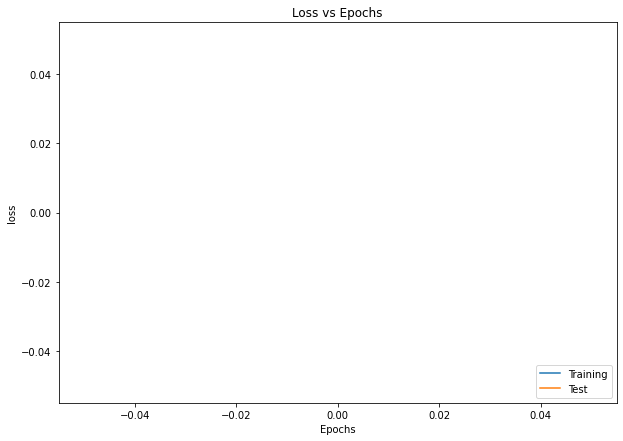

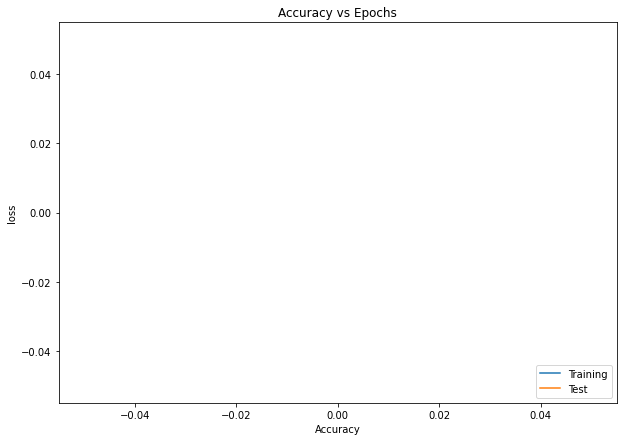

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
fig1, ax_acc = plt.subplots()
plt.plot(losses)
plt.plot(losses_test)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show ()

fig2, ax_loss = plt.subplots()
plt.plot(accur)
plt.plot(accur_test)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show ()